In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA available?:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.4.1
Is CUDA available?: True
CUDA device name: NVIDIA GeForce RTX 4070


In [46]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm  # For progress bar
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import re

In [8]:
# read data
data = pd.read_csv('data_clean.csv', encoding='latin-1')

In [11]:
# Text cleaning function for BERT
def text_clean_for_bert(text):
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)  # remove numbers
    # Remove emojis (optional)
    emoji_pattern = re.compile("[" 
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # supplemental arrows
                               u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
                               u"\U0001FA00-\U0001FA6F"  # chess symbols
                               u"\U0001FA70-\U0001FAFF"  # symbols and pictographs extended
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"  # Enclosed characters
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # We keep punctuation for BERT, no need to tokenize manually
    return text.strip()

In [13]:
data['bert_clean'] = data['statement'].apply(text_clean_for_bert)

In [15]:
encoder = LabelEncoder()
data.loc[:, 'status_encoded'] = encoder.fit_transform(data['status'])

In [17]:
class_names = encoder.classes_
category_mapping = dict(zip(class_names, range(len(class_names))))

print("Category mapping:", category_mapping)

Category mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


## Train Test Splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data['bert_clean'], data['status_encoded'], test_size=0.2, random_state=42,stratify = data['status_encoded'])

## Tokenize Data

In [75]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function with long labels
def tokenize_data(texts, labels, max_len=256):
    inputs = tokenizer(
        texts.tolist(),  # Convert to list if it's a pandas Series or NumPy array
        padding=True, 
        truncation=True, 
        max_length=max_len, 
        return_tensors="pt"
    )
    # Convert labels to long type
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels.values, dtype=torch.long))
    return dataset

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Tokenize X_train and X_test
train_dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
        elif val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # Reset the counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exceeded

# Function to evaluate model on a given dataset
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            # Move inputs and labels to device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            # Make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
model.config.hidden_dropout_prob = 0.3  # Ensure dropout is set

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to training mode
model.train()

# Define optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define learning rate scheduler (ReduceLROnPlateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6, verbose=True)

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Fine-tuning loop with early stopping and learning rate scheduling
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Append the training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Clear GPU memory
    torch.cuda.empty_cache()

# After training, evaluate final performance
train_loss, train_accuracy = evaluate(model, train_loader)
test_loss, test_accuracy = evaluate(model, test_loader)

print(f'Final Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
Train Loss: 0.7344, Train Accuracy: 71.53%
Val Loss: 0.4883, Val Accuracy: 80.30%
Epoch 2/10
Train Loss: 0.4316, Train Accuracy: 82.77%
Val Loss: 0.4325, Val Accuracy: 82.52%
Epoch 3/10
Train Loss: 0.3487, Train Accuracy: 85.95%
Val Loss: 0.4380, Val Accuracy: 82.64%
Epoch 4/10
Train Loss: 0.2836, Train Accuracy: 88.60%
Val Loss: 0.4376, Val Accuracy: 82.52%
Early stopping
Final Training Accuracy: 93.13%
Final Test Accuracy: 82.52%


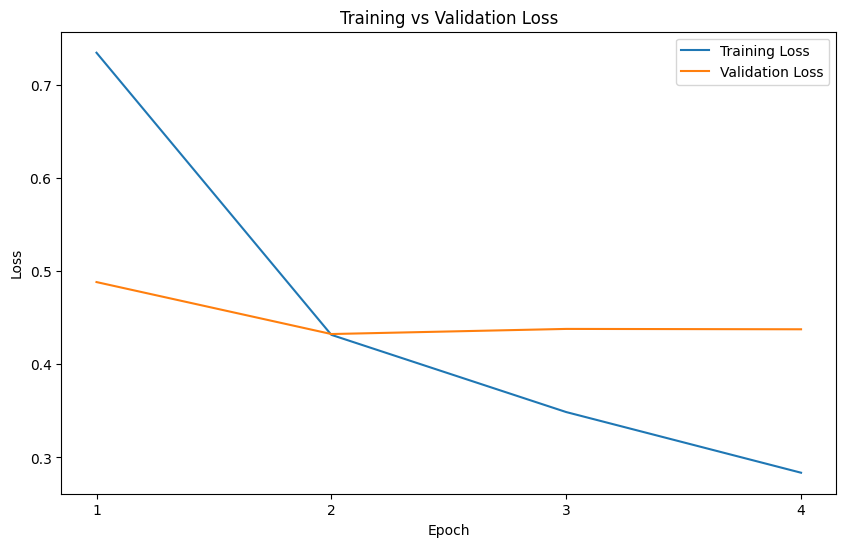

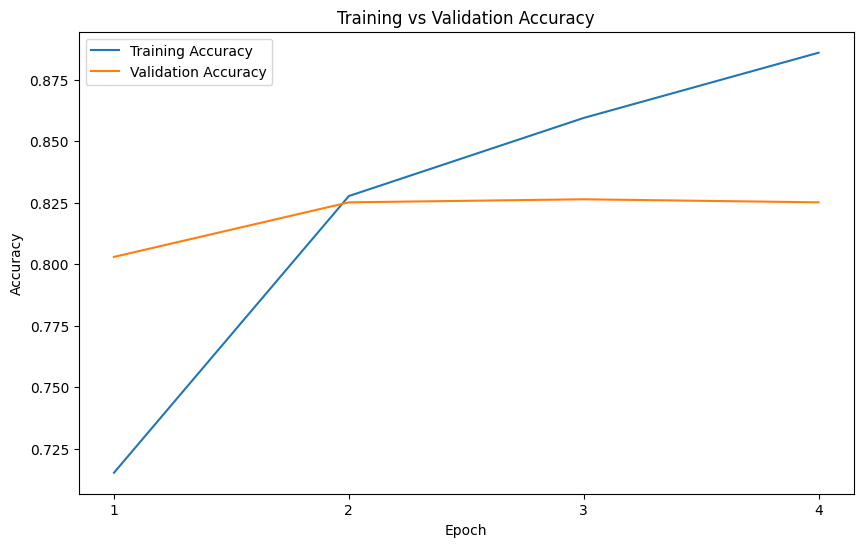

In [31]:
# Create a range for the x-axis starting from 1
epochs = range(1, len(train_losses) + 1)

# Plot Train vs Validation Loss graph
plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.xticks(epochs)  # Ensure x-axis ticks correspond to epoch numbers starting from 1
plt.legend()
plt.show()

# Plot Train vs Validation Accuracy graph
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xticks(epochs)  # Ensure x-axis ticks correspond to epoch numbers starting from 1
plt.legend()
plt.show()


At the second epoch validation loss is minimized. We will rerun two epochs and then decrease learning rate.

In [34]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
        elif val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # Reset the counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exceeded

# Function to evaluate model on a given dataset
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            # Move inputs and labels to device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            # Make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
model.config.hidden_dropout_prob = 0.3  # Ensure dropout is set

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to training mode
model.train()

# Define optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define learning rate scheduler (ReduceLROnPlateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6, verbose=True)

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Fine-tuning loop with early stopping and learning rate scheduling
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Append the training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Clear GPU memory
    torch.cuda.empty_cache()

# After training, evaluate final performance
train_loss, train_accuracy = evaluate(model, train_loader)
test_loss, test_accuracy = evaluate(model, test_loader)

print(f'Final Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/2
Train Loss: 0.7464, Train Accuracy: 71.58%
Val Loss: 0.4901, Val Accuracy: 80.32%
Epoch 2/2
Train Loss: 0.4376, Train Accuracy: 82.54%
Val Loss: 0.4265, Val Accuracy: 82.11%
Final Training Accuracy: 86.89%
Final Test Accuracy: 82.11%


In [37]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'fine_tuned_bert_model1.pth')

In [ ]:
# Reload the model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# Load the state dictionary
model.load_state_dict(torch.load('fine_tuned_bert_model.pth'))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

## Decrease Learning Rate

In [39]:
# Set model to training mode
model.train()

# Define optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define learning rate scheduler (ReduceLROnPlateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-7, verbose=True)

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Fine-tuning loop with early stopping and learning rate scheduling
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Append the training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Clear GPU memory
    torch.cuda.empty_cache()

# After training, evaluate final performance
train_loss, train_accuracy = evaluate(model, train_loader)
test_loss, test_accuracy = evaluate(model, test_loader)

print(f'Final Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/2
Train Loss: 0.3331, Train Accuracy: 86.74%
Val Loss: 0.4150, Val Accuracy: 83.19%
Epoch 2/2
Train Loss: 0.3170, Train Accuracy: 87.50%
Val Loss: 0.4188, Val Accuracy: 83.07%
Final Training Accuracy: 89.04%
Final Test Accuracy: 83.07%


In [41]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'fine_tuned_bert_model.pth')

In [43]:
# Collect true labels and predictions
y_true = []
y_pred = []

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        
        # Move predictions and labels back to CPU and convert to numpy arrays
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compare y_pred and y_true
print(f'Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print(classification_report(y_true, y_pred))


Accuracy: 83.07%
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       714
           1       0.85      0.83      0.84       500
           2       0.82      0.75      0.78      2971
           3       0.95      0.96      0.95      2718
           4       0.78      0.65      0.71       179
           5       0.73      0.77      0.75       458
           6       0.72      0.79      0.75      2110

    accuracy                           0.83      9650
   macro avg       0.82      0.80      0.81      9650
weighted avg       0.83      0.83      0.83      9650



## Cross Validation

In [76]:
# Number of folds for cross-validation
k_folds = 5

# Define KFold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True)

# Track losses and accuracies for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

# Define total epochs
num_epochs = 4  # 2 epochs at lr=1e-5 and 2 epochs at lr=1e-6

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Create data loaders for this fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32)
    
    # Load fresh pre-trained BERT model for each fold
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
    model.config.hidden_dropout_prob = 0.3  # Ensure dropout is set
    model.to(device)
    
    # Define optimizer with initial learning rate 1e-5
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    
    # Define learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6, verbose=True)
    
    # Instantiate EarlyStopping
    early_stopping = EarlyStopping(patience=2, min_delta=0.001)
    
    # Train for 2 epochs with learning rate 1e-5, then reduce to 1e-6 for next 2 epochs
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / total_samples

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Adjust learning rate manually after 2 epochs
        if epoch == 1:
            print("Reducing learning rate to 1e-6")
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6

        # Clear GPU memory
        torch.cuda.empty_cache()
        
    # Record metrics for this fold
    fold_train_losses.append(avg_train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)

# After cross-validation, calculate the average metrics
print("\nCross-Validation Results:")
print(f"Average Training Loss: {np.mean(fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(fold_val_losses):.4f}")
print(f"Average Training Accuracy: {np.mean(fold_train_accuracies) * 100:.2f}%")
print(f"Average Validation Accuracy: {np.mean(fold_val_accuracies) * 100:.2f}%")


Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/4
Train Loss: 0.7387, Train Accuracy: 72.02%
Val Loss: 0.5018, Val Accuracy: 80.65%
Epoch 2/4
Train Loss: 0.4421, Train Accuracy: 82.37%
Val Loss: 0.4535, Val Accuracy: 81.85%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.3349, Train Accuracy: 86.74%
Val Loss: 0.4424, Val Accuracy: 82.60%
Epoch 4/4
Train Loss: 0.3169, Train Accuracy: 87.56%
Val Loss: 0.4424, Val Accuracy: 82.51%
Fold 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train Loss: 0.7429, Train Accuracy: 71.74%
Val Loss: 0.5008, Val Accuracy: 80.21%
Epoch 2/4
Train Loss: 0.4351, Train Accuracy: 82.73%
Val Loss: 0.4500, Val Accuracy: 81.80%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.3317, Train Accuracy: 86.97%
Val Loss: 0.4380, Val Accuracy: 82.36%
Epoch 4/4
Train Loss: 0.3156, Train Accuracy: 87.67%
Val Loss: 0.4442, Val Accuracy: 82.01%
Fold 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train Loss: 0.7420, Train Accuracy: 71.94%
Val Loss: 0.4981, Val Accuracy: 80.28%
Epoch 2/4
Train Loss: 0.4464, Train Accuracy: 82.13%
Val Loss: 0.4650, Val Accuracy: 80.89%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.3430, Train Accuracy: 86.44%
Val Loss: 0.4371, Val Accuracy: 82.71%
Epoch 4/4
Train Loss: 0.3260, Train Accuracy: 87.11%
Val Loss: 0.4397, Val Accuracy: 82.58%
Fold 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train Loss: 0.7985, Train Accuracy: 69.55%
Val Loss: 0.5091, Val Accuracy: 79.56%
Epoch 2/4
Train Loss: 0.4592, Train Accuracy: 81.87%
Val Loss: 0.4535, Val Accuracy: 81.53%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.3498, Train Accuracy: 86.39%
Val Loss: 0.4349, Val Accuracy: 82.56%
Epoch 4/4
Train Loss: 0.3333, Train Accuracy: 86.79%
Val Loss: 0.4365, Val Accuracy: 82.49%
Fold 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Train Loss: 0.7671, Train Accuracy: 70.95%
Val Loss: 0.5528, Val Accuracy: 77.35%
Epoch 2/4
Train Loss: 0.4443, Train Accuracy: 82.42%
Val Loss: 0.4619, Val Accuracy: 81.01%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.3359, Train Accuracy: 86.88%
Val Loss: 0.4418, Val Accuracy: 82.20%
Epoch 4/4
Train Loss: 0.3187, Train Accuracy: 87.53%
Val Loss: 0.4426, Val Accuracy: 82.25%

Cross-Validation Results:
Average Training Loss: 0.3221
Average Validation Loss: 0.4411
Average Training Accuracy: 87.33%
Average Validation Accuracy: 82.37%


In [62]:
fold_val_accuracies

[0.7984455958549223,
 0.8145077720207254,
 0.8266839378238342,
 0.8244818652849741,
 0.8244818652849741,
 0.7927461139896373,
 0.8132124352331607,
 0.8200777202072539,
 0.8217616580310881,
 0.8217616580310881,
 0.7905440414507772,
 0.8194300518134715,
 0.8264248704663213,
 0.8244818652849741,
 0.8244818652849741,
 0.7848445595854923,
 0.8125647668393783,
 0.8235751295336787,
 0.8269430051813471,
 0.8269430051813471,
 0.7994558880684026,
 0.8191475579738308,
 0.8258841818888457,
 0.8284751910869284,
 0.8284751910869284]

# Drop Personality Disorder and Stress, Combine Depression and Suicidal

Personality Disorder and Stress have a small number of instances in the dataset, so we will drop them. Depression and Suicidal share overlapping characteristics, so we will combine them into one class.

In [64]:
# Create a new dataframe to keep the original data intact
data_modified2 = data.copy()

# Combine class 0 and 5 into one class, and 2 and 6 into another class
class_mapping = {
    0: 0,  # Keep class 0 as it is
    2: 2, 6: 2,  # Combine classes 2 and 6 into class 2
    1: 1,        # Keep class 1 as it is
    3: 3,        # Keep class 3 as it is
    4: 4,         # Keep class 4 as it is for now
    5:5    # Keep class 5 as it is for now
}

# Replace class labels in the new dataframe
data_modified2['status_combined'] = data_modified2['status_encoded'].replace(class_mapping)

# Drop rows where the class is 4,5 from the new dataframe
data_filtered2 = data_modified2[(data_modified2['status_combined'] != 4) & (data_modified2['status_combined'] != 5)]

# Print the distribution of the new classes
print(data_filtered2['status_combined'].value_counts())

status_combined
2    25406
3    13590
0     3571
1     2501
Name: count, dtype: int64


In [66]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(data_filtered2['bert_clean'], data_filtered2['status_combined'], test_size=0.2, random_state=42,stratify = data_filtered2['status_combined'])

## Tokenize The Data

In [78]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function with long labels
def tokenize_data(texts, labels, max_len=256):
    inputs = tokenizer(
        texts.tolist(),  # Convert to list if it's a pandas Series or NumPy array
        padding=True, 
        truncation=True, 
        max_length=max_len, 
        return_tensors="pt"
    )
    # Convert labels to long type
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels.values, dtype=torch.long))
    return dataset

y_train4 = y_train4.astype(int)
y_test4 = y_test4.astype(int)

# Tokenize X_train and X_test
train_dataset = tokenize_data(X_train4, y_train4)
test_dataset = tokenize_data(X_test4, y_test4)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Bert Model Fine Tuning

In [79]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
        elif val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # Reset the counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exceeded

# Function to evaluate model on a given dataset
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            # Move inputs and labels to device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            # Make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
model.config.hidden_dropout_prob = 0.3  # Ensure dropout is set

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to training mode
model.train()

# Define optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define learning rate scheduler (ReduceLROnPlateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6, verbose=True)

# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Fine-tuning loop with early stopping and learning rate scheduling
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=-1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Append the training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Adjust learning rate manually after 2 epochs
    if epoch == 1:
        print("Reducing learning rate to 1e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-6
                
    # Adjust learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Clear GPU memory
    torch.cuda.empty_cache()

# After training, evaluate final performance
train_loss, train_accuracy = evaluate(model, train_loader)
test_loss, test_accuracy = evaluate(model, test_loader)

print(f'Final Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')


C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Betul\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/4
Train Loss: 0.2977, Train Accuracy: 90.42%
Val Loss: 0.1432, Val Accuracy: 95.33%
Epoch 2/4
Train Loss: 0.1070, Train Accuracy: 96.61%
Val Loss: 0.1227, Val Accuracy: 95.85%
Reducing learning rate to 1e-6
Epoch 3/4
Train Loss: 0.0547, Train Accuracy: 98.35%
Val Loss: 0.1124, Val Accuracy: 96.33%
Epoch 4/4
Train Loss: 0.0463, Train Accuracy: 98.70%
Val Loss: 0.1157, Val Accuracy: 96.31%
Final Training Accuracy: 99.05%
Final Test Accuracy: 96.31%


With combined classes the accuracy increases to 96%.

## Training Time

Fine Tuning time of Bert Model is around 15-25 minutes with GPU.